# House prices other approaches

This model intends to be simple. Since there are lots of variables for a small number of instances, overfitting is a serious issue. So, I'll select a few variables beforehand that are the most important ones according to domain experts.

A quick domain research shows that the price of a house is mostly influenced by:

- Prices of similar houses in the neighborhood
- Location (Proximity to schools, employment oportunities, entertainment, ...)
- Size and Usuable space
- Age and condition
- Number of bedrooms and bathrooms
- Garage

In [120]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import joblib
from scipy.stats.distributions import uniform, randint
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('train.csv')

In [3]:
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

In [4]:
num_cols = df.columns[(df.dtypes == 'int64').ravel()].drop(['Id', 'MSSubClass'])

In [5]:
df_num = df.loc[:, num_cols]

In [6]:
corr_var = df_num.agg([lambda x: pd.DataFrame(x).corrwith(df['SalePrice'], method='kendall')[0], 
            lambda x:x.std()/x.mean()], axis=0).drop(['SalePrice'], axis=1).T
corr_var.columns = ['Correlation', 'VarCoeff']
corr_var = corr_var.applymap(abs).sort_values('Correlation', ascending=False).T
corr_var

,OverallQual,GarageCars,GrLivArea,FullBath,GarageArea,YearBuilt,TotalBsmtSF,YearRemodAdd,Fireplaces,1stFlrSF,...,OverallCond,ScreenPorch,LowQualFinSF,3SsnPorch,MiscVal,MoSold,PoolArea,BsmtFinSF2,YrSold,BsmtHalfBath
Correlation,0.669660,0.572168,0.543942,0.518693,0.478146,0.470960,0.435018,0.412955,0.412829,0.411556,...,0.103492,0.080654,0.055308,0.053478,0.050917,0.049471,0.047800,0.030710,0.021796,0.009962
VarCoeff,0.226746,0.422899,0.346746,0.352007,0.452038,0.015322,0.414879,0.010401,1.051635,0.332512,...,0.199593,3.702116,8.319430,8.598494,11.408001,0.427659,14.562778,3.465556,0.000661,4.149748


In [7]:
cols_corr = corr_var.columns

In [8]:
cols_corr

Index(['OverallQual', 'GarageCars', 'GrLivArea', 'FullBath', 'GarageArea',
       'YearBuilt', 'TotalBsmtSF', 'YearRemodAdd', 'Fireplaces', '1stFlrSF',
       'TotRmsAbvGrd', 'OpenPorchSF', 'LotArea', 'HalfBath', 'WoodDeckSF',
       '2ndFlrSF', 'BsmtFinSF1', 'BedroomAbvGr', 'BsmtFullBath',
       'EnclosedPorch', 'KitchenAbvGr', 'BsmtUnfSF', 'OverallCond',
       'ScreenPorch', 'LowQualFinSF', '3SsnPorch', 'MiscVal', 'MoSold',
       'PoolArea', 'BsmtFinSF2', 'YrSold', 'BsmtHalfBath'],
      dtype='object')

In [9]:
def write_test(mod,name):
    df_t = pd.read_csv('test.csv')
    df_pred = pd.concat([df_t.Id, pd.Series(mod.predict(df_t), name='SalePrice')], axis=1)
    df_pred.to_csv(name, index=False)

In [11]:
class Preprocessing_Select(TransformerMixin, BaseEstimator):
    """ Simple transformation and Select Variables to work with """
    # House_Age = YrSold - YrBuilt | To assign a scale
    def __init__(self, vars_corr=None, k=None):
        self.vars_corr = vars_corr
        if k:
            self.k = k
        else:
            self.k = len(vars_corr)
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Xt = X.copy()
        Xt['YearBuilt'] = Xt['YrSold'] - Xt['YearBuilt']
        Xt['YearRemodAdd'] = Xt['YrSold'] - Xt['YearRemodAdd']
        return Xt[self.vars_corr[:self.k]]

In [84]:
pipe_RF = Pipeline([
    ('Preprocess', Preprocessing_Select(vars_corr=cols_corr)),
    ('Impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('Predict', RandomForestRegressor(n_jobs=-1,random_state=42))]
)

In [85]:
grid_params = {
    'Preprocess__k':list(range(1, len(cols_corr)))
}

In [86]:
grid_RF = GridSearchCV(pipe_RF, param_grid=grid_params, cv=10, scoring='neg_mean_squared_log_error')

In [87]:
grid_RF.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Preprocess',
                                        Preprocessing_Select(k=32,
                                                             vars_corr=Index(['OverallQual', 'GarageCars', 'GrLivArea', 'FullBath', 'GarageArea',
       'YearBuilt', 'TotalBsmtSF', 'YearRemodAdd', 'Fireplaces', '1stFlrSF',
       'TotRmsAbvGrd', 'OpenPorchSF', 'LotArea', 'HalfBath', 'WoodDeckSF',
       '2ndFlrSF', 'BsmtFinSF1', 'BedroomAbvGr', 'BsmtFullBath',
       'En...
       'ScreenPorch', 'LowQualFinSF', '3SsnPorch', 'MiscVal', 'MoSold',
       'PoolArea', 'BsmtFinSF2', 'YrSold', 'BsmtHalfBath'],
      dtype='object'))),
                                       ('Impute',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('Predict',
                                        RandomForestRegressor(n_jobs=-1,
      

In [108]:
grid_RF.best_params_

{'Preprocess__k': 26}

In [236]:
#write_test(grid_RF.best_estimator_, 'RF_Selected_Variables.csv')

**The best estimator is with k = 26 variables**

### Trying Extra Trees

In [115]:
pipe_RFExtra = Pipeline([
    ('Preprocess', Preprocessing_Select(vars_corr=cols_corr, k=26)),
    ('Impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('Predict', ExtraTreesRegressor(n_jobs=-1))]
)

cross_val_score(pipe_RFExtra, X, y, cv = 10, scoring='neg_mean_squared_log_error').mean()

-0.020643281794012418

In [113]:
pipe_RFExtra.fit(X, y)

Pipeline(steps=[('Preprocess',
                 Preprocessing_Select(k=25,
                                      vars_corr=Index(['OverallQual', 'GarageCars', 'GrLivArea', 'FullBath', 'GarageArea',
       'YearBuilt', 'TotalBsmtSF', 'YearRemodAdd', 'Fireplaces', '1stFlrSF',
       'TotRmsAbvGrd', 'OpenPorchSF', 'LotArea', 'HalfBath', 'WoodDeckSF',
       '2ndFlrSF', 'BsmtFinSF1', 'BedroomAbvGr', 'BsmtFullBath',
       'EnclosedPorch', 'KitchenAbvGr', 'BsmtUnfSF', 'OverallCond',
       'ScreenPorch', 'LowQualFinSF', '3SsnPorch', 'MiscVal', 'MoSold',
       'PoolArea', 'BsmtFinSF2', 'YrSold', 'BsmtHalfBath'],
      dtype='object'))),
                ('Impute', SimpleImputer(fill_value=0, strategy='constant')),
                ('Predict', ExtraTreesRegressor(n_jobs=-1))])

In [114]:
write_test(pipe_RFExtra, 'ExtraRF_Selected_Variables4.csv')

### Analyzing the results

In [89]:
results =grid_RF.cv_results_['mean_test_score']

In [29]:
#joblib.dump(results, 'variable_selection_score.pkl')
#results = joblib.load('variable_selection_score.pkl')

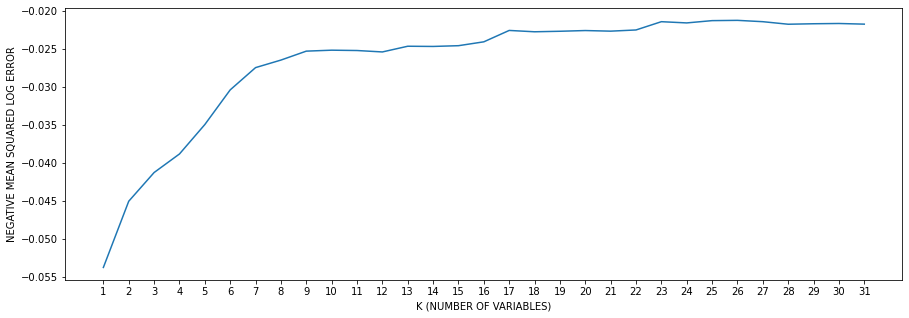

In [97]:
plt.figure(figsize=(15, 5))
plt.plot(range(1,len(cols_corr)), results)
plt.xlabel('K (NUMBER OF VARIABLES)')
plt.xticks(range(1, len(cols_corr)))
plt.ylabel('NEGATIVE MEAN SQUARED LOG ERROR')
plt.show()

Text(0.5, 0, 'MEAN SQUARED LOG ERROR AFTER ADDING VARIABLE')

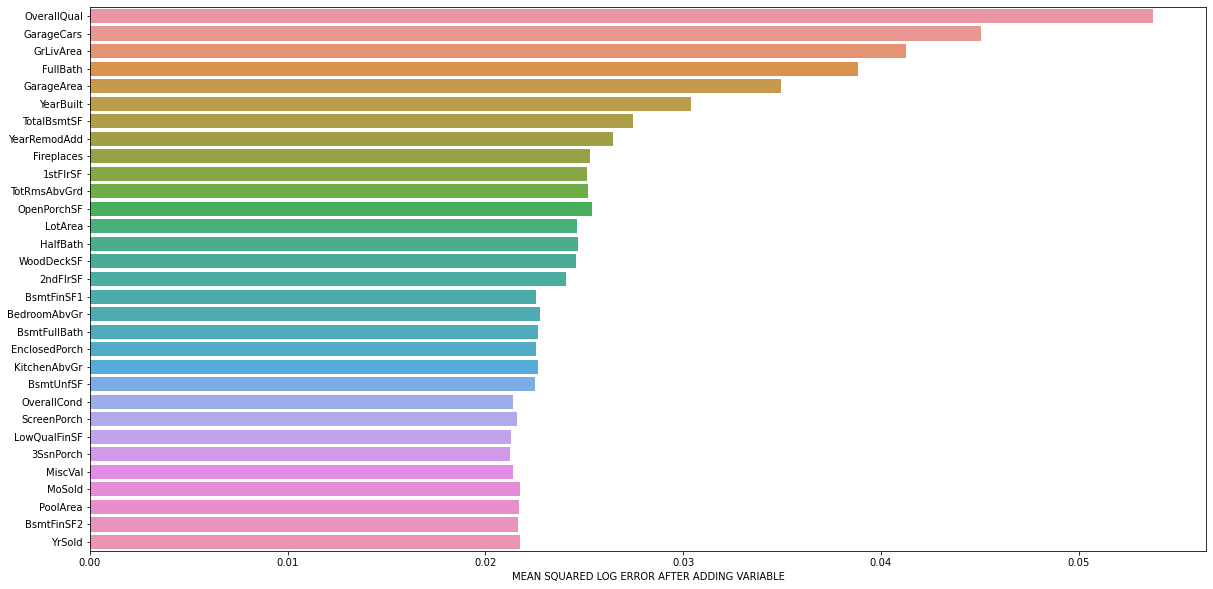

In [98]:
plt.figure(figsize=(20,10))
sns.barplot(y=cols_corr[:-1], x=abs(results))
plt.xlabel('MEAN SQUARED LOG ERROR AFTER ADDING VARIABLE')

Text(0.5, 0, 'BUMP IN SCORE AFTER ADDING VARIABLE')

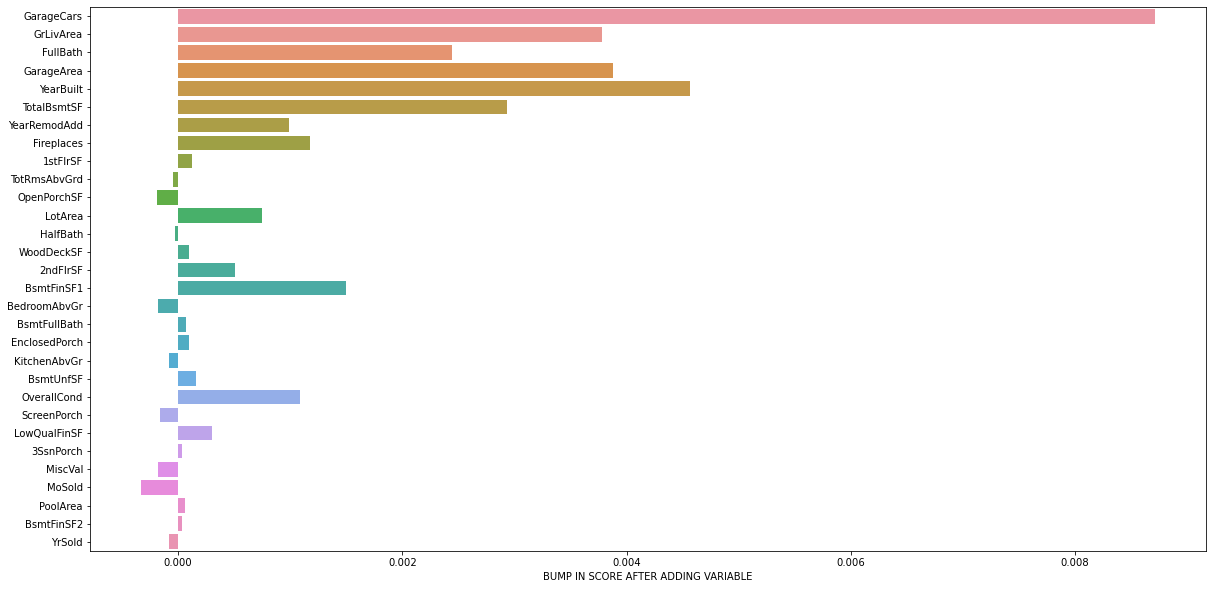

In [99]:
bump = np.diff(results)
plt.figure(figsize=(20,10))
sns.barplot(y=cols_corr[1:-1], x=bump)
plt.xlabel('BUMP IN SCORE AFTER ADDING VARIABLE')

### Selecting only variables with significant bumps

In [100]:
bump

array([ 8.71320091e-03,  3.77711616e-03,  2.44178830e-03,  3.87342416e-03,
        4.56068912e-03,  2.93111683e-03,  9.91936574e-04,  1.17553077e-03,
        1.26256128e-04, -4.38538813e-05, -1.88302904e-04,  7.51394582e-04,
       -2.70842149e-05,  9.90367870e-05,  5.08955040e-04,  1.49858816e-03,
       -1.76606759e-04,  6.71776732e-05,  9.46161201e-05, -7.98233293e-05,
        1.56259656e-04,  1.08919915e-03, -1.61666908e-04,  3.01118162e-04,
        3.63589210e-05, -1.75686102e-04, -3.34258629e-04,  6.27977292e-05,
        3.40182240e-05, -8.53938217e-05])

In [101]:
best_vars = np.insert(cols_corr[1:-1][bump > 0], 0, 'OverallQual')

In [68]:
#joblib.dump(best_vars, 'vars_positive_bump.csv')

In [103]:
len(best_vars)

22

In [105]:
pipe_RFExtra_bestvars = Pipeline([
    ('Preprocess', Preprocessing_Select(vars_corr=best_vars)),
    ('Impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('Predict', ExtraTreesRegressor(n_jobs=-1, random_state=42))]
)

cross_val_score(pipe_RFExtra_bestvars, X, y, cv = 10, scoring='neg_mean_squared_log_error').mean()

-0.020842966905589257

In [106]:
pipe_RFExtra_bestvars.fit(X, y)

Pipeline(steps=[('Preprocess',
                 Preprocessing_Select(k=22,
                                      vars_corr=Index(['OverallQual', 'GarageCars', 'GrLivArea', 'FullBath', 'GarageArea',
       'YearBuilt', 'TotalBsmtSF', 'YearRemodAdd', 'Fireplaces', '1stFlrSF',
       'LotArea', 'WoodDeckSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFullBath',
       'EnclosedPorch', 'BsmtUnfSF', 'OverallCond', 'LowQualFinSF',
       '3SsnPorch', 'PoolArea', 'BsmtFinSF2'],
      dtype='object'))),
                ('Impute', SimpleImputer(fill_value=0, strategy='constant')),
                ('Predict', ExtraTreesRegressor(n_jobs=-1, random_state=42))])

## Num Pipeline

In [124]:
num_pipe = Pipeline([
    ('Preprocess', Preprocessing_Select(vars_corr=cols_corr, k=26)),
    ('Impute', SimpleImputer(strategy='constant', fill_value=0))])

## Categorical Variables

In [197]:
cat_pipe = Pipeline([
    ('Impute_cat', SimpleImputer(strategy='most_frequent')),
    ('OneHot', OneHotEncoder(handle_unknown='ignore'))])

Since location is very important to determine a house price, the variable **neighborhood** should be useful.

In [212]:
?ExtraTreesRegressor

In [198]:
full_preprocess = ColumnTransformer([
    ('Numerical', num_pipe, cols_corr),
    ('Categorical', cat_pipe, ['Neighborhood'])])

In [208]:
transf_predictEXT = Pipeline([
    ('Transform', full_preprocess),
    ('Predict', ExtraTreesRegressor(n_jobs=-1))
])

In [223]:
param_grid = {
    'Transform__Numerical__Preprocess__k':[26],
    'Predict__n_estimators':randint(80, 120),
    'Predict__max_features':uniform(0.6, 0.4),
    'Predict__bootstrap':[False, True]
}

In [224]:
grid_full_pipe_RF = RandomizedSearchCV(transf_predictEXT, param_distributions=param_grid, cv=10, scoring='neg_mean_squared_log_error',
                                      n_iter=30)

In [225]:
grid_full_pipe_RF.fit(X, y)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Transform',
                                              ColumnTransformer(transformers=[('Numerical',
                                                                               Pipeline(steps=[('Preprocess',
                                                                                                Preprocessing_Select(k=26,
                                                                                                                     vars_corr=Index(['OverallQual', 'GarageCars', 'GrLivArea', 'FullBath', 'GarageArea',
       'YearBuilt', 'TotalBsmtSF', 'YearRemodAdd', 'Fireplaces', '1stFlrSF',
       'TotRmsAbvGrd', 'OpenPorchSF', 'LotArea', '...
                                              ExtraTreesRegressor(n_jobs=-1))]),
                   n_iter=30,
                   param_distributions={'Predict__bootstrap': [False, True],
                                        'Predict__max_features': <sci

In [228]:
grid_full_pipe_RF.best_score_

-0.018590455405247647

In [235]:
grid_full_pipe_RF.cv_results_['mean_test_score'], grid_full_pipe_RF.cv_results_['std_test_score']

(array([-0.01916892, -0.01926158, -0.01859046, -0.01935044, -0.01923471,
        -0.01972934, -0.0190666 , -0.01924418, -0.01883609, -0.01938761,
        -0.01905131, -0.0188836 , -0.01926618, -0.01899516, -0.01913515,
        -0.01941457, -0.01939885, -0.0192223 , -0.01943783, -0.01906005,
        -0.01926678, -0.01962699, -0.01906127, -0.01911035, -0.01939431,
        -0.01885474, -0.01890687, -0.01907298, -0.0188659 , -0.01904454]),
 array([0.00550554, 0.00510945, 0.00507504, 0.00527681, 0.00525819,
        0.00551571, 0.00512225, 0.00541422, 0.00557532, 0.00542238,
        0.00526204, 0.00532705, 0.00525353, 0.00547927, 0.00517364,
        0.00541947, 0.00542083, 0.00537388, 0.00573941, 0.00517752,
        0.00525447, 0.00544002, 0.00549473, 0.00535931, 0.00529363,
        0.00524663, 0.00531994, 0.00528503, 0.0054152 , 0.00508617]))

In [238]:
write_test(grid_full_pipe_RF.best_estimator_, 'RF_Num_Neighborhood_Tunned2.csv')